In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
from numba import  njit

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
from numba import  njit

class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [9]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [29]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

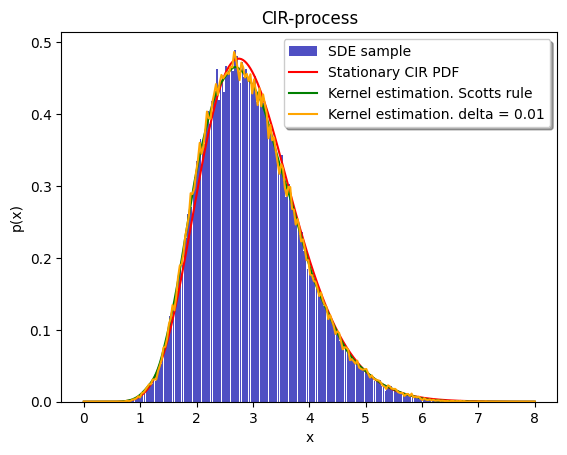

In [12]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)
d = 0.01
original_a1 = CIRp.StationaryDistribution(x_data)       # Исходные данные
approximation1_a1 = StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()) # Первое приближение
approximation2_a1= StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d) # Второе приближение

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')


ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()



In [ ]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

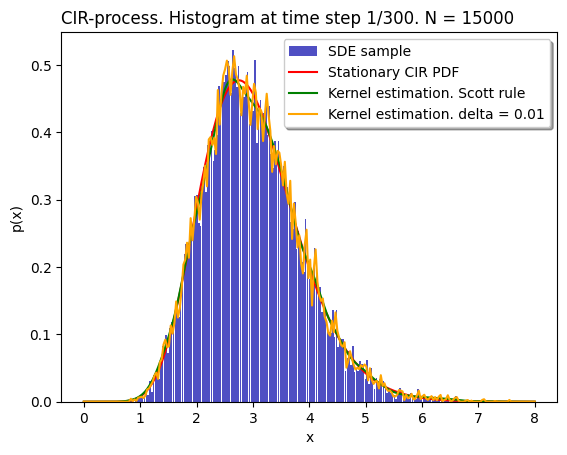

In [ ]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

original_a2 = CIRp.StationaryDistribution(x_data)       # Исходные данные
approximation1_a2 = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]) # Первое приближение
approximation2_a2 = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d) # Второе приближение

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel

# Ваши массивы с данными
original = original_a1      # Исходные данные
approximation1 = approximation1_a1 # Первое приближение
approximation2 = approximation2_a1 # Второе приближение

# Функция для оценки качества приближения
def evaluate_approximation(original, approximation):
    mse = mean_squared_error(original, approximation)
    mae = mean_absolute_error(original, approximation)
    r2 = r2_score(original, approximation)
    return mse, mae, r2

# Оценка для первого приближения
mse1, mae1, r2_1 = evaluate_approximation(original, approximation1)
print(f"Приближение 1 - MSE: {mse1}, MAE: {mae1}, R²: {r2_1}")

# Оценка для второго приближения
mse2, mae2, r2_2 = evaluate_approximation(original, approximation2)
print(f"Приближение 2 - MSE: {mse2}, MAE: {mae2}, R²: {r2_2}")

# Сравнение приближений с помощью t-теста
t_stat1, p_val1 = ttest_rel(original, approximation1)
t_stat2, p_val2 = ttest_rel(original, approximation2)

print(f"Приближение 1 - t-статистика: {t_stat1}, p-значение: {p_val1}")
print(f"Приближение 2 - t-статистика: {t_stat2}, p-значение: {p_val2}")

# Заключение по результатам теста
if p_val1 < 0.05:
    print("Приближение 1 статистически значимо отличается от исходных данных.")
else:
    print("Приближение 1 не имеет статистически значимых отличий от исходных данных.")

if p_val2 < 0.05:
    print("Приближение 2 статистически значимо отличается от исходных данных.")
else:
    print("Приближение 2 не имеет статистически значимых отличий от исходных данных.")


Приближение 1 - MSE: 1.7065915197225e-05, MAE: 0.0023236304647147794, R²: 0.9993530514425603
Приближение 2 - MSE: 5.479820683151016e-05, MAE: 0.004285528407932679, R²: 0.9979226651222493
Приближение 1 - t-статистика: -0.007760355504668474, p-значение: 0.9938144080901028
Приближение 2 - t-статистика: 0.07564950281772996, p-значение: 0.9397586955792369
Приближение 1 не имеет статистически значимых отличий от исходных данных.
Приближение 2 не имеет статистически значимых отличий от исходных данных.


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel

# Ваши массивы с данными
original = original_a2     # Исходные данные
approximation1 = approximation1_a2 # Первое приближение
approximation2 = approximation2_a2 # Второе приближение

# Функция для оценки качества приближения
def evaluate_approximation(original, approximation):
    mse = mean_squared_error(original, approximation)
    mae = mean_absolute_error(original, approximation)
    r2 = r2_score(original, approximation)
    return mse, mae, r2

# Оценка для первого приближения
mse1, mae1, r2_1 = evaluate_approximation(original, approximation1)
print(f"Приближение 1 - MSE: {mse1}, MAE: {mae1}, R²: {r2_1}")

# Оценка для второго приближения
mse2, mae2, r2_2 = evaluate_approximation(original, approximation2)
print(f"Приближение 2 - MSE: {mse2}, MAE: {mae2}, R²: {r2_2}")

# Сравнение приближений с помощью t-теста
t_stat1, p_val1 = ttest_rel(original, approximation1)
t_stat2, p_val2 = ttest_rel(original, approximation2)

print(f"Приближение 1 - t-статистика: {t_stat1}, p-значение: {p_val1}")
print(f"Приближение 2 - t-статистика: {t_stat2}, p-значение: {p_val2}")

# Заключение по результатам теста
if p_val1 < 0.05:
    print("Приближение 1 статистически значимо отличается от исходных данных.")
else:
    print("Приближение 1 не имеет статистически значимых отличий от исходных данных.")

if p_val2 < 0.05:
    print("Приближение 2 статистически значимо отличается от исходных данных.")
else:
    print("Приближение 2 не имеет статистически значимых отличий от исходных данных.")


Приближение 1 - MSE: 2.351770960639294e-05, MAE: 0.0028929588142936626, R²: 0.9991084715862987
Приближение 2 - MSE: 0.0002416118101218686, MAE: 0.00929091685555679, R²: 0.9908407835025356
Приближение 1 - t-статистика: -0.006607292937336007, p-значение: 0.9947334718087297
Приближение 2 - t-статистика: -0.01349870113119293, p-значение: 0.9892407310437128
Приближение 1 не имеет статистически значимых отличий от исходных данных.
Приближение 2 не имеет статистически значимых отличий от исходных данных.


Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

In [ ]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

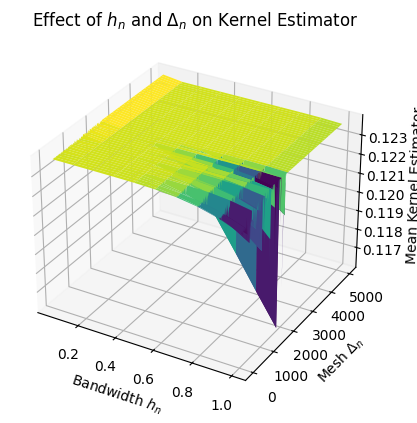

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Задаем диапазоны для h_n и Delta_n
hn_values = np.linspace(0.05, 1, 10)  # Полоса пропускания
delta_n_values = np.arange(1, 5000, 10)  # Шаг сетки

# Подготовка сетки для графика
X, Y = np.meshgrid(hn_values, delta_n_values)
Z = np.zeros_like(X)

# Подготовка данных
x_data_points = np.linspace(0, 8, 100)

# Вычисление ядерной оценки для каждой пары h_n и Delta_n
for i, hn in enumerate(hn_values):
    for j, delta_n in enumerate(delta_n_values):
        sampled_data = x_data_CIR.flatten()[::delta_n]  # Применяем интервал выборки
        kernel_estimation = StationaryDistributionKernelEstimator(x_data_points, sampled_data[::delta_n], delta=hn)
        Z[j, i] = np.mean(kernel_estimation)  # Среднее значение для общей оценки

# Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis)

# Настройки графика
ax.set_xlabel("Bandwidth $h_n$")
ax.set_ylabel("Mesh $\\Delta_n$")
ax.set_zlabel("Mean Kernel Estimator")
ax.set_title("Effect of $h_n$ and $\\Delta_n$ on Kernel Estimator")

plt.show()


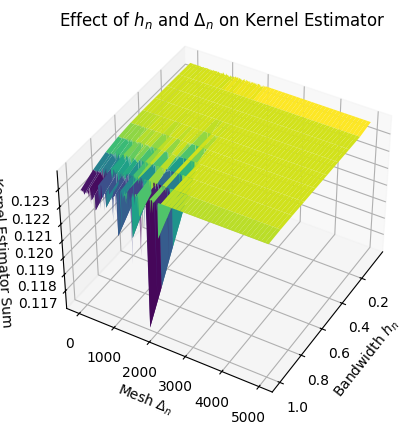

In [ ]:
# Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis)
ax.view_init(40, 30)

# Настройки графика
ax.set_xlabel("Bandwidth $h_n$")
ax.set_ylabel("Mesh $\\Delta_n$")
ax.set_zlabel("Kernel Estimator Sum")
ax.set_title("Effect of $h_n$ and $\\Delta_n$ on Kernel Estimator")

plt.show()

Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

In [51]:
from scipy.stats import gaussian_kde

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * (x ** params[3])

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x ** (params[3] - 1)

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x ** (params[3] - 2)

    def DefaultInitState(self):
        return  - self.params[0] / self.params[1] * np.ones(self.Nx, dtype=np.float64)

    def ExactSolution(self, dwt=None):
        raise NotImplementedError("Точное решение для модели CKLS аналитически не существует.")

    def StationaryState(self):
        raise NotImplementedError("Стационарное состояние для модели CKLS аналитически не определено.")

    def ProcessDistribution(self, x, t, x0, t0):
        raise NotImplementedError("Распределение процесса для модели CKLS аналитически не определено.")

    def StationaryDistribution(self, x):
        raise NotImplementedError("Стационарное распределение для модели CKLS аналитически не определено.")

In [59]:
# approach 2

Nx = 1000
Nt = 300

T = 1

params_CKLS = [1., 2., 0.5, 0.3]

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
# CKLS.init_state = CKLS.DefaultInitState()
CKLS.init_state = 2 * np.ones(Nx, dtype=np.float64)
t_data, x_data_CKLS = CKLS.EulerSolution()

In [63]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [70]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CKLS = [1., 2., 0.5, 0.3]

CKLSp = CKLSprocess(params_CKLS, T, Nx, Nt)
# CKLp.init_state = CKLp.StationaryState()
# Стационарное состояние для модели CKLS аналитически не определено
CKLSp.init_state = 2 * np.ones(Nx, dtype=np.float64)
# Точное решение для модели CKLS аналитически не существует.
# t_data, x_data_CKL = CKLSp.ExactSolution()
t_data, x_data_CKL = CKLSp.EulerSolution()

<ipython-input-8-57d9d0ea032b>:69: RuntimeWarning: invalid value encountered in add
  x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\


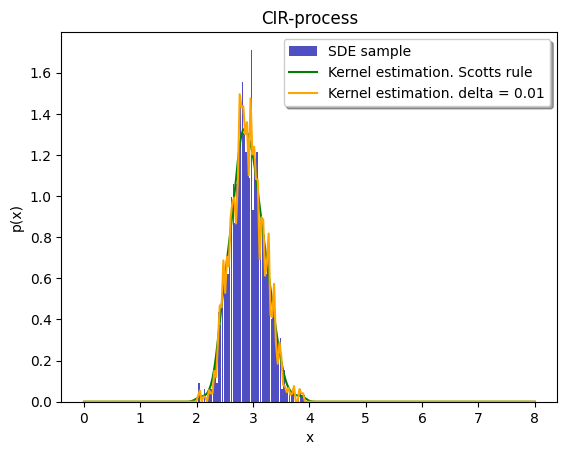

In [87]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, 300)

original_a1 = x_data_CKLS[i]       # Исходные данные
approximation1_a1 = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i]) # Первое приближение
approximation2_a1= StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d) # Второе приближение

n, bins, patches = ax.hist(x_data_CKLS[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

# ax.plot(x_data, CKLSp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i]), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()



In [73]:
# approach 2

Nx = 15000
Nt = 300

T = 1


params_CKLS = [1., 2., 0.5, 0.3]

CKLSp = CKLSprocess(params_CKLS, T, Nx, Nt)
# CKLp.init_state = CKLp.StationaryState()
# Стационарное состояние для модели CKLS аналитически не определено
CKLSp.init_state = 2 * np.ones(Nx, dtype=np.float64)
# Точное решение для модели CKLS аналитически не существует.
# t_data, x_data_CKL = CKLSp.ExactSolution()
t_data, x_data_CKL = CKLSp.EulerSolution()

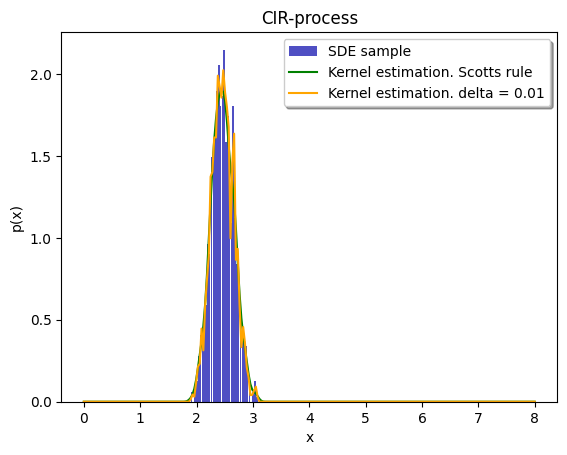

In [97]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, 300)

# original_a1 = CKLSp.StationaryDistribution(x_data)       # Исходные данные
approximation1_a2 = StationaryDistributionKernelEstimator(x_data, x_data_CKLS.flatten()) # Первое приближение
approximation2_a2 = StationaryDistributionKernelEstimator(x_data, x_data_CKLS.flatten(), delta = d) # Второе приближение

n, bins, patches = ax.hist(x_data_CKLS[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

# ax.plot(x_data, CKLSp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i]), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()



In [105]:
len(original_a1[:250]), len(approximation1_a1)

(250, 250)

In [107]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel

# Ваши массивы с данными
original = approximation1_a1     # Исходные данные
approximation1 = approximation1_a1 # Первое приближение
approximation2 = approximation2_a1 # Второе приближение

# Функция для оценки качества приближения
def evaluate_approximation(original, approximation):
    mse = mean_squared_error(original, approximation)
    mae = mean_absolute_error(original, approximation)
    r2 = r2_score(original, approximation)
    return mse, mae, r2

# Оценка для первого приближения
mse1, mae1, r2_1 = evaluate_approximation(original, approximation1)
print(f"Приближение 1 - MSE: {mse1}, MAE: {mae1}, R²: {r2_1}")

# Оценка для второго приближения
mse2, mae2, r2_2 = evaluate_approximation(original, approximation2)
print(f"Приближение 2 - MSE: {mse2}, MAE: {mae2}, R²: {r2_2}")

# Сравнение приближений с помощью t-теста
t_stat1, p_val1 = ttest_rel(original, approximation1)
t_stat2, p_val2 = ttest_rel(original, approximation2)

print(f"Приближение 1 - t-статистика: {t_stat1}, p-значение: {p_val1}")
print(f"Приближение 2 - t-статистика: {t_stat2}, p-значение: {p_val2}")

# Заключение по результатам теста
if p_val1 < 0.05:
    print("Приближение 1 статистически значимо отличается от исходных данных.")
else:
    print("Приближение 1 не имеет статистически значимых отличий от исходных данных.")

if p_val2 < 0.05:
    print("Приближение 2 статистически значимо отличается от исходных данных.")
else:
    print("Приближение 2 не имеет статистически значимых отличий от исходных данных.")


Приближение 1 - MSE: 0.0, MAE: 0.0, R²: 1.0
Приближение 2 - MSE: 0.0021206365152964556, MAE: 0.01632098881151272, R²: 0.9788665111240629
Приближение 1 - t-статистика: nan, p-значение: nan
Приближение 2 - t-статистика: 0.3373522433288087, p-значение: 0.7361355794280404
Приближение 1 не имеет статистически значимых отличий от исходных данных.
Приближение 2 не имеет статистически значимых отличий от исходных данных.


In [112]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel

# Ваши массивы с данными
# original = original_a2     # Исходные данные
approximation1 = approximation1_a1 # Первое приближение
approximation2 = approximation2_a1 # Второе приближение

# Функция для оценки качества приближения
def evaluate_approximation(original, approximation):
    mse = mean_squared_error(original, approximation)
    mae = mean_absolute_error(original, approximation)
    r2 = r2_score(original, approximation)
    return mse, mae, r2

# Оценка приближения
mse1, mae1, r2_1 = evaluate_approximation(approximation1, approximation2)
print(f"Приближение - MSE: {mse1}, MAE: {mae1}, R²: {r2_1}")


# Сравнение приближений с помощью t-теста
t_stat1, p_val1 = ttest_rel(approximation1, approximation2)

print(f"Приближение - t-статистика: {t_stat1}, p-значение: {p_val1}")

# Заключение по результатам теста
if p_val1 < 0.05:
    print("Приближение статистически значимо отличается.")
else:
    print("Приближение не имеет статистически значимых отличий.")



Приближение - MSE: 0.0021206365152964556, MAE: 0.01632098881151272, R²: 0.9788665111240629
Приближение - t-статистика: 0.3373522433288087, p-значение: 0.7361355794280404
Приближение не имеет статистически значимых отличий.


In [113]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel

# Ваши массивы с данными
# original = original_a2     # Исходные данные
approximation1 = approximation1_a2 # Первое приближение
approximation2 = approximation2_a2 # Второе приближение

# Функция для оценки качества приближения
def evaluate_approximation(original, approximation):
    mse = mean_squared_error(original, approximation)
    mae = mean_absolute_error(original, approximation)
    r2 = r2_score(original, approximation)
    return mse, mae, r2

# Оценка приближения
mse1, mae1, r2_1 = evaluate_approximation(approximation1, approximation2)
print(f"Приближение - MSE: {mse1}, MAE: {mae1}, R²: {r2_1}")


# Сравнение приближений с помощью t-теста
t_stat1, p_val1 = ttest_rel(approximation1, approximation2)

print(f"Приближение - t-статистика: {t_stat1}, p-значение: {p_val1}")

# Заключение по результатам теста
if p_val1 < 0.05:
    print("Приближение статистически значимо отличается.")
else:
    print("Приближение не имеет статистически значимых отличий.")



Приближение - MSE: 0.00038029365974764906, MAE: 0.008337647602983642, R²: 0.8185104848800155
Приближение - t-статистика: -0.07598062797838719, p-значение: 0.9394955215315898
Приближение не имеет статистически значимых отличий.


In [114]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

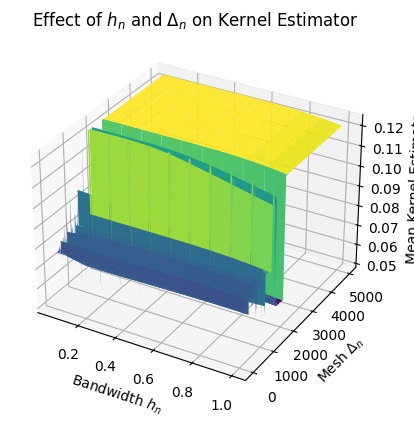

In [115]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Задаем диапазоны для h_n и Delta_n
hn_values = np.linspace(0.05, 1, 10)  # Полоса пропускания
delta_n_values = np.arange(1, 5000, 10)  # Шаг сетки

# Подготовка сетки для графика
X, Y = np.meshgrid(hn_values, delta_n_values)
Z = np.zeros_like(X)

# Подготовка данных
x_data_points = np.linspace(0, 8, 100)

# Вычисление ядерной оценки для каждой пары h_n и Delta_n
for i, hn in enumerate(hn_values):
    for j, delta_n in enumerate(delta_n_values):
        sampled_data = x_data_CKL.flatten()[::delta_n]  # Применяем интервал выборки
        kernel_estimation = StationaryDistributionKernelEstimator(x_data_points, sampled_data[::delta_n], delta=hn)
        Z[j, i] = np.mean(kernel_estimation)  # Среднее значение для общей оценки

# Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis)

# Настройки графика
ax.set_xlabel("Bandwidth $h_n$")
ax.set_ylabel("Mesh $\\Delta_n$")
ax.set_zlabel("Mean Kernel Estimator")
ax.set_title("Effect of $h_n$ and $\\Delta_n$ on Kernel Estimator")

plt.show()


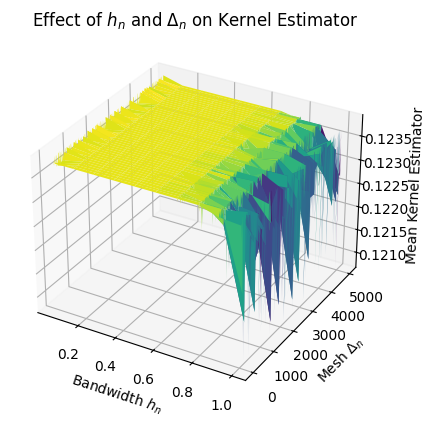

In [116]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Задаем диапазоны для h_n и Delta_n
hn_values = np.linspace(0.05, 1, 10)  # Полоса пропускания
delta_n_values = np.arange(1, 5000, 10)  # Шаг сетки

# Подготовка сетки для графика
X, Y = np.meshgrid(hn_values, delta_n_values)
Z = np.zeros_like(X)

# Подготовка данных
x_data_points = np.linspace(0, 8, 100)

# Вычисление ядерной оценки для каждой пары h_n и Delta_n
for i, hn in enumerate(hn_values):
    for j, delta_n in enumerate(delta_n_values):
        k = np.random.randint(30, 100)
        sampled_data = x_data_CKL[k][::delta_n]  # Применяем интервал выборки
        kernel_estimation = StationaryDistributionKernelEstimator(x_data_points, sampled_data[::delta_n], delta=hn)
        Z[j, i] = np.mean(kernel_estimation)  # Среднее значение для общей оценки

# Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis)

# Настройки графика
ax.set_xlabel("Bandwidth $h_n$")
ax.set_ylabel("Mesh $\\Delta_n$")
ax.set_zlabel("Mean Kernel Estimator")
ax.set_title("Effect of $h_n$ and $\\Delta_n$ on Kernel Estimator")

plt.show()


Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [125]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def DiffusionKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [126]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

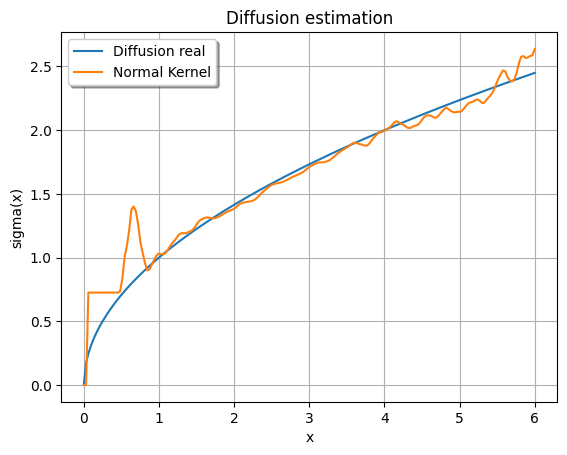

In [127]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, np.sqrt(diffke), label = 'Parabolic Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, np.sqrt(diffke), label = 'Uniform Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

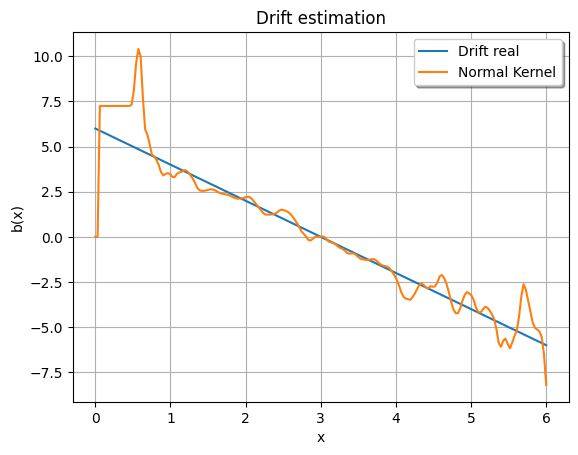

In [128]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, driftke, label = 'Parabolic Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, driftke, label = 'Uniform Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


In [129]:
def Gaussian_high_order(z):
    return 3 / np.sqrt(8 * np.pi) * (1 - z**2 / 3) * np.exp(-z**2 / 2)

In [130]:
def DiffusionKernelEstimator_g(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        K = Gaussian_high_order(z)

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator_g(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        K = Gaussian_high_order(z)

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

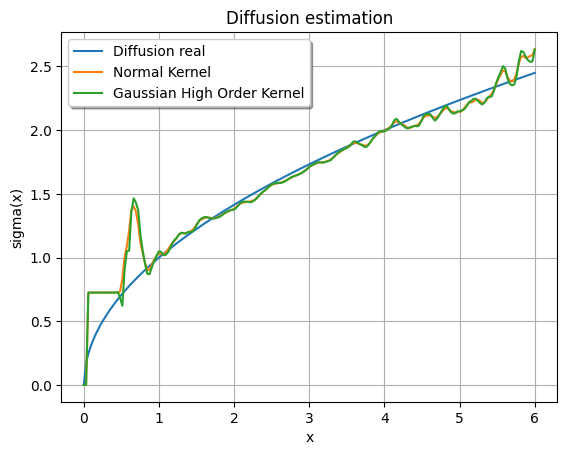

In [131]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')

diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

diffke = DiffusionKernelEstimator_g(x_data, x_data_CIR.flatten(), T/Nt)
plt.plot(x_data, np.sqrt(diffke), label = 'Gaussian High Order Kernel')


plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

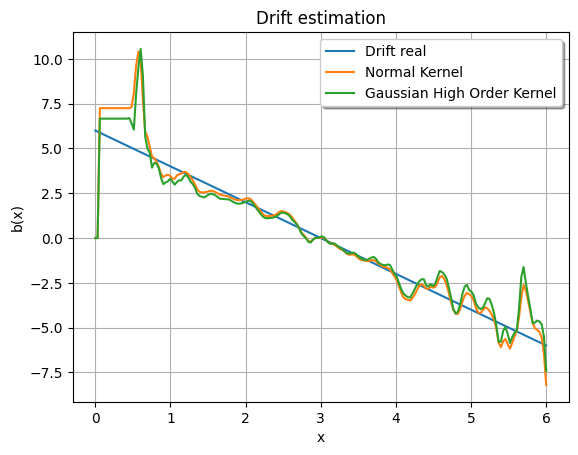

In [132]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

# driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
# plt.plot(x_data, driftke, label = 'Parabolic Kernel')

# driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
# plt.plot(x_data, driftke, label = 'Uniform Kernel')


# from paper https://www.nber.org/system/files/working_papers/w5345/w5345.pdf
# optimal bandwidth = h_n = c_n * n^{-1 / (1 + 2r)} = c_n * n ^ {-1/9}, c_n = c/log(n)
c = .45
hn = c * Nt ** (- 1 / 9) / np.log(Nt)

driftke = DriftKernelEstimator_g(x_data, x_data_CIR.flatten(), hn)
plt.plot(x_data, driftke, label = 'Gaussian High Order Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()